<a href="https://colab.research.google.com/github/caglakarayilanoglu/Hello-World/blob/master/Predicting_Avocado_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Update necessary packages first
!pip3 uninstall --yes fbprophet
!pip3 install fbprophet --no-cache-dir --no-binary :all:
!pip3 install pydotplus --no-cache-dir --no-binary :all:

In [2]:
# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore") # Don't want to see the warnings in the notebook
from sklearn import svm

In [3]:
# downloading and describing the dataset

df = pd.read_csv('../content/avocado.csv')
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


Some relevant columns in the dataset:

Date - The date of the observation

AveragePrice - the average price of a single avocado

type - conventional or organic

year - the year

Region - the city or region of the observation

Total Volume - Total number of avocados sold

4046 - Total number of avocados with PLU 4046 sold  (Small Hass)

4225 - Total number of avocados with PLU 4225 sold  (Large Hass)

4770 - Total number of avocados with PLU 4770 sold  (XLarge Hass)


Weekly 2018 retail scan data for National retail volume (units) and price.

Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados.

The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags.

The Product Lookup codes (PLU’s) in the table are only for Hass avocados.

Other varieties of avocados (e.g. greenskins) are not included in this table.

In [4]:
df.isnull().sum()     # is there any NULL variable in the dataset?

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

In [5]:
df.describe().round(2)

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.00,18249.00,18249.00,18249.00,18249.00,18249.00,18249.00,18249.00,18249.00,18249.00,18249.00
mean,24.23,1.41,850644.01,293008.42,295154.57,22839.74,239639.20,182194.69,54338.09,3106.43,2016.15
std,15.48,0.40,3453545.36,1264989.08,1204120.40,107464.07,986242.40,746178.51,243965.96,17692.89,0.94
min,0.00,0.44,84.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2015.00
25%,10.00,1.10,10838.58,854.07,3008.78,0.00,5088.64,2849.42,127.47,0.00,2015.00
50%,24.00,1.37,107376.76,8645.30,29061.02,184.99,39743.83,26362.82,2647.71,0.00,2016.00
75%,38.00,1.66,432962.29,111020.20,150206.86,6243.42,110783.37,83337.67,22029.25,132.50,2017.00
max,52.00,3.25,62505646.52,22743616.17,20470572.61,2546439.11,19373134.37,13384586.80,5719096.61,551693.65,2018.00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


# To summarise the dataset we see;

* 14 columns (variables) and 18249 rows (observations)

* There isn't any NULL variable

* data types: float64(9), int64(2), object(3)

* there are some unnamed/undefined columns

* 'region','type' and 'date' columns are in object format

In [7]:
# Target of this project is to predict the future price of avocados depending on those variables we have;

# * Type     *Bags(4 units) vs Bundle(one unit)     *Region      *Volume      *Size     *Years

In [8]:
# PREPROCESSING

# drop unnamed column and rename undefined columns;

df = df.drop(['Unnamed: 0'], axis = 1)

df = df.rename(index=str, columns={"4046" : "Small Hass", "4225" : "Large Hass","4770" : "XLarge Hass" })

In [9]:
# convert Date column's format;

df['Date'] =pd.to_datetime(df.Date)

df.sort_values(by=['Date'], inplace=True, ascending=True)

df.head()

,Date,AveragePrice,Total Volume,Small Hass,Large Hass,XLarge Hass,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
11569,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
9593,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago
10009,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
1819,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh
9333,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise


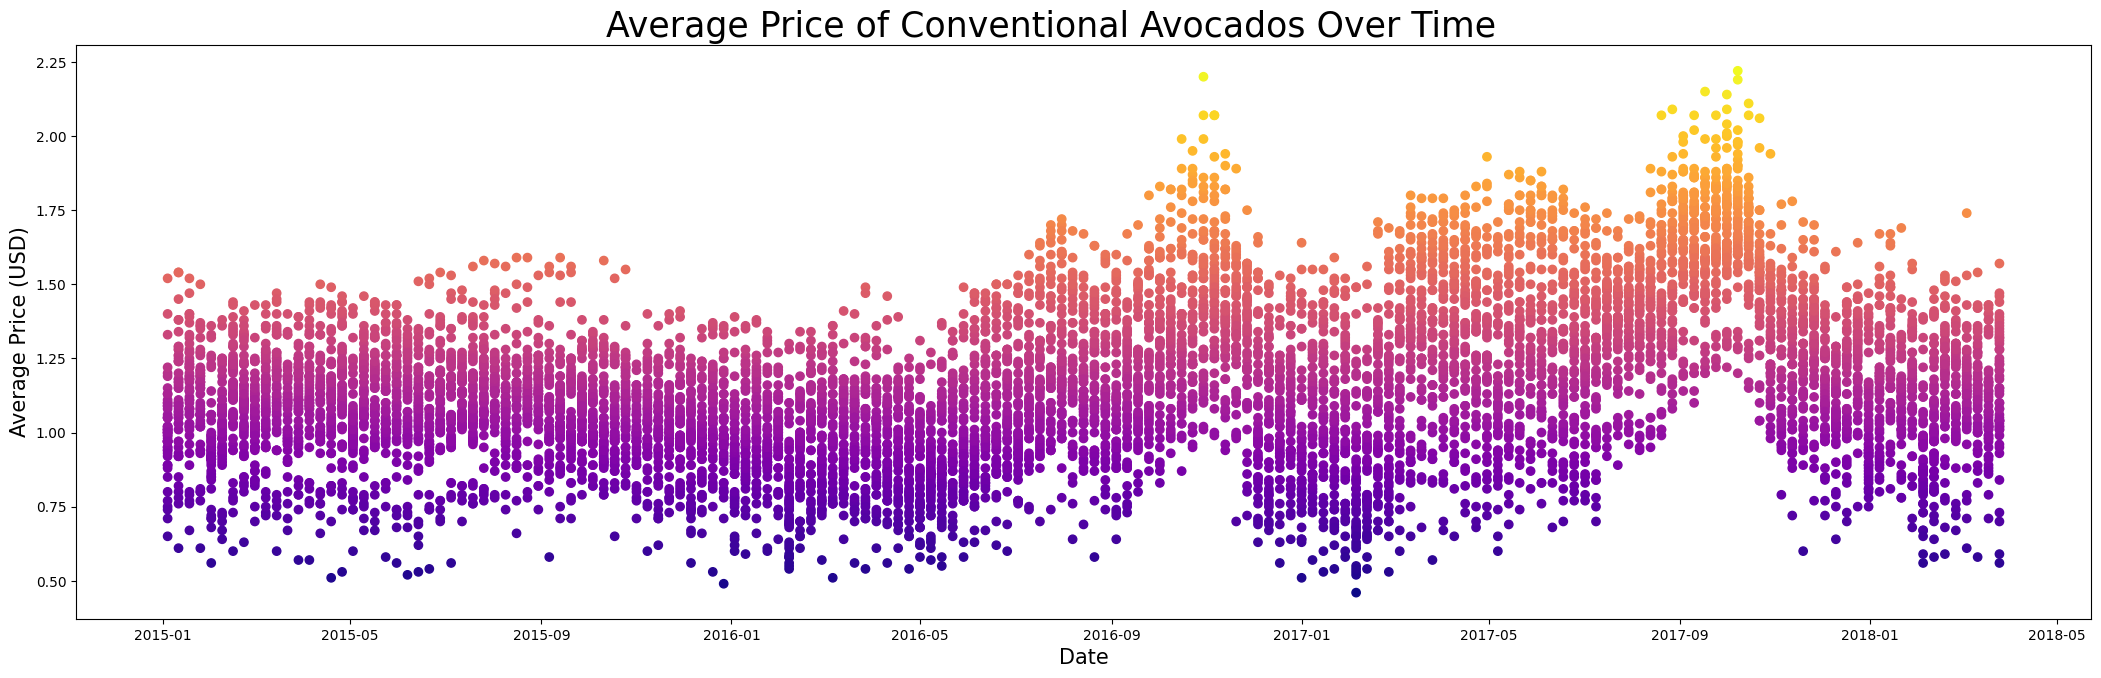

In [10]:
# Average price of Conventional Avocados over time

mask = df['type']== 'conventional'
plt.rc('figure', titlesize=50)
fig = plt.figure(figsize = (26, 7))
fig.suptitle('Average Price of Conventional Avocados Over Time', fontsize=25)
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.93)

dates = df[mask]['Date'].tolist()
avgPrices = df[mask]['AveragePrice'].tolist()

plt.scatter(dates, avgPrices, c=avgPrices, cmap='plasma')
ax.set_xlabel('Date',fontsize = 15)
ax.set_ylabel('Average Price (USD)', fontsize = 15)
plt.show()

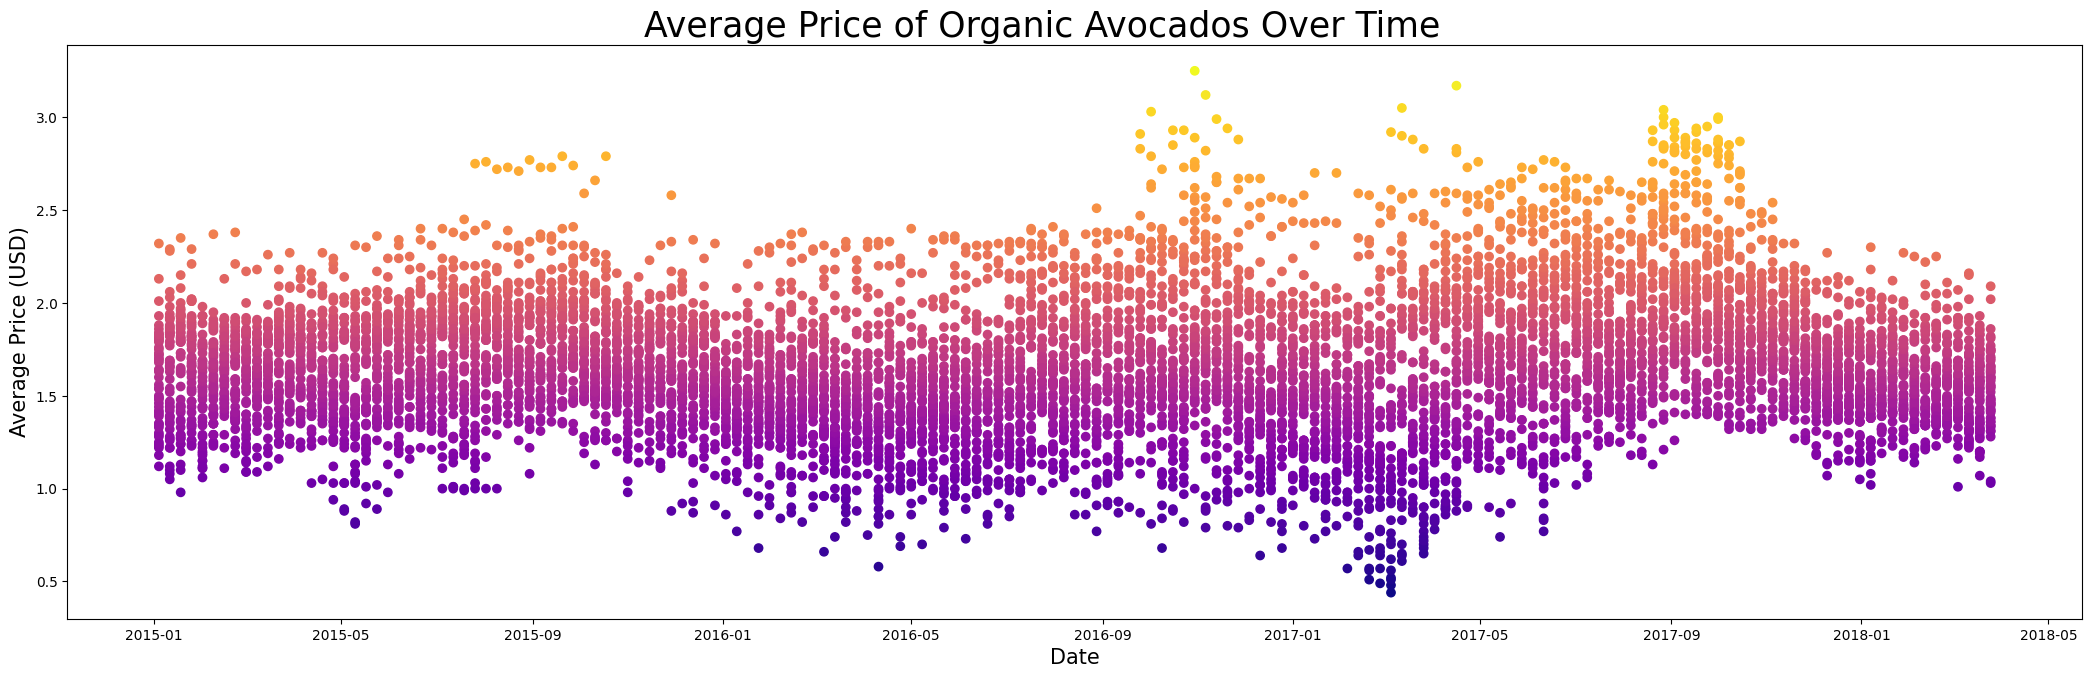

In [11]:
# Average price of Organic Avocados over time
mask = df['type']== 'organic'
plt.rc('figure', titlesize=50)
fig = plt.figure(figsize = (26, 7))
fig.suptitle('Average Price of Organic Avocados Over Time', fontsize=25)
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.93)

dates = df[mask]['Date'].tolist()
avgPrices = df[mask]['AveragePrice'].tolist()

plt.scatter(dates, avgPrices, c=avgPrices, cmap='plasma')
ax.set_xlabel('Date',fontsize = 15)
ax.set_ylabel('Average Price (USD)', fontsize = 15)
plt.show()

In [12]:
# TIME SERIES ANALYSIS

# Since the data itself is a time series data, I first want to see time series analysis predictions, and then apply ML models.

# Creating a two-column dataset to use in time series analysis;

df2 = df[['Date', 'AveragePrice']]
df2 = df2.set_index('Date')

weekly_df = df2.resample('W').mean()
w_df = weekly_df.reset_index().dropna()

w_df.sort_values(by=['Date'])
w_df.head()

,Date,AveragePrice
0,2015-01-04,1.301296
1,2015-01-11,1.370648
2,2015-01-18,1.391111
3,2015-01-25,1.397130
4,2015-02-01,1.247037


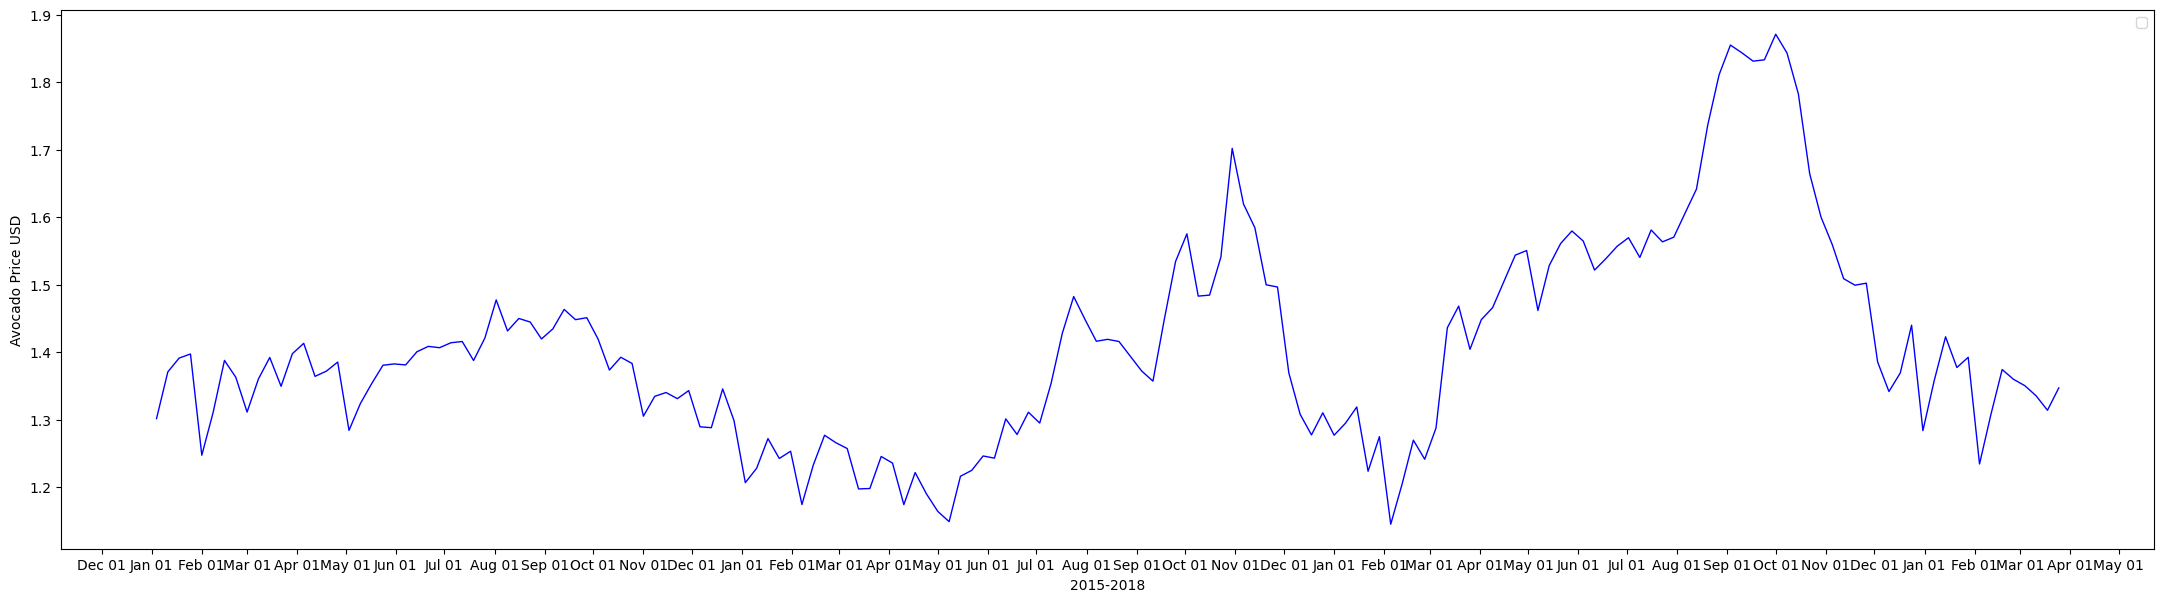

In [13]:
# Plotting the weekly average prices by month;

import matplotlib.dates as mdates


fig = plt.figure(figsize = (27, 7))
ax = plt.axes()
#set ticks every month
ax.xaxis.set_major_locator(mdates.MonthLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.plot(w_df['Date'],w_df['AveragePrice'],color='b', linewidth=1)
plt.xlabel("2015-2018")
plt.ylabel("Avocado Price USD")
plt.legend()
plt.show()

In [14]:
# Time Series Forecasts using Facebook's Prophet()

w_df.columns = ['ds', 'y']

from fbprophet import Prophet

P=Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=False, changepoint_range=1)
#interval_width sets the uncertainty interval to produce a confidence interval around the forecast

P.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)


P.fit(w_df)

future = P.make_future_dataframe(freq='W', periods=4)  # Let's predict the next month's average prices

future.tail()



In [ ]:
from fbprophet.plot import add_changepoints_to_plot

forecast = P.predict(future)
fig = P.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), P, forecast)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig2 = P.plot_components(forecast)

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(P, initial = '365 days', period = '30 days', horizon = '30 days')

df_cv.tail()

In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.tail()

In [ ]:
np.mean(df_p['mape'])

In [ ]:
np.mean(df_p['rmse'])

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
# mean absolute percentage error MAPE

In [ ]:
forecastnew = forecast['ds']
forecastnew2 = forecast['yhat']

forecastnew = pd.concat([forecastnew,forecastnew2], axis=1)

mask = (forecastnew['ds'] > "2018-03-24") & (forecastnew['ds'] <= "2020-09-10")
forecastedvalues = forecastnew.loc[mask]

mask = (forecastnew['ds'] > "2015-01-04") & (forecastnew['ds'] <= "2018-03-25")
forecastnew = forecastnew.loc[mask]

forecastedvalues

# Predictions for the next month are as follows;

In [ ]:
# We already know that y=1.347 for 2018-03-25, and the model prediction is 1.388, which is actually over 3% of the real value.


In [ ]:
fig, ax1 = plt.subplots(figsize=(21, 5))
ax1.plot(forecastnew.set_index('ds'), color='b')
ax1.plot(forecastedvalues.set_index('ds'), color='r')
ax1.set_ylabel('Average Prices')
ax1.set_xlabel('Date')
print("Red = Predicted Values, Blue = Base Values")

In [ ]:
# With Facebook Prophet() we obtain forecasts which are off by 8% due to MAPE values. (Accuracy= 92%)

# The Prophet predicts future prices in a downward trend.

In [ ]:
# Now, Let's see what we get from Machine Learning Algorithms!

In [ ]:
# Dropping the Date column (date format is not suitable for next level analysis (i.e. OHE))
df = df.drop(['Date'], axis = 1)

In [ ]:
# Checking if the sample is balanced;
df.groupby('region').size() # Approximately, there are 338 observations from each region, sample seems balanced.

In [ ]:
len(df.region.unique())

In [ ]:
df.region.unique() # There are 54 regions but some are subsets of the other regions, i.e: San Francisco-California

In [ ]:
# basically we can remove states and work on cities rather than analysing both (to prevent multicollinerarity)

regionsToRemove = ['California', 'GreatLakes', 'Midsouth', 'NewYork', 'Northeast', 'SouthCarolina', 'Plains', 'SouthCentral', 'Southeast', 'TotalUS', 'West']
df = df[~df.region.isin(regionsToRemove)]
len(df.region.unique())

In [ ]:
# The average prices by regions

plt.figure(figsize=(10,11))
plt.title("Avg.Price of Avocado by Region")
Av= sns.barplot(x="AveragePrice",y="region",data= df)

In [ ]:
type_counts = df.groupby('type').size()
print(type_counts)

# Types of avocados are also balanced since the ratio is almost 0.5

In [ ]:
# The average prices of avocados by types; organic or not

plt.figure(figsize=(5,7))
plt.title("Avg.Price of Avocados by Type")
Av= sns.barplot(x="type",y="AveragePrice",data= df)

In [ ]:
# Total Bags = Small Bags + Large Bags + XLarge Bags

# To avoid multicollinearity I'll keep S-L-XL bags and drop Total Bags

# But before droping we'd better to see the correlation between those columns:

df[['Small Hass', "Large Hass", "XLarge Hass",'Small Bags','Large Bags','XLarge Bags','Total Volume','Total Bags']].corr()

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),cmap='coolwarm',annot=True)

# darker = stronger

In [ ]:
# There is a high correlation between those pairs:
# small hass & total volume  (0.89)
# total bags & total volume  (0.87)
# small bags & total bags    (0.96)

# Small Hass avocados are the most preferred/sold type in the US and customers tend to buy those avocados as bulk, not bag.
# Retailers want to increase the sales of bagged avocados instead of bulks. They think this is more advantageous for them.
# Total Bags variable has a very high correlation with Total Volume (Total Sales) and Small Bags, so we can say that most
#of the bagged sales comes from the small bags.

In [ ]:
df_V = df.drop(['AveragePrice', 'Total Volume', 'Total Bags'], axis = 1).groupby('year').agg('sum')
df_V

In [ ]:
indexes = ['Small Hass', 'Large Hass', 'XLarge Hass', 'Small Bags', 'Large Bags', 'XLarge Bags']
series = pd.DataFrame({'2015': df_V.loc[[2015],:].values.tolist()[0],
                      '2016': df_V.loc[[2016],:].values.tolist()[0],
                      '2017': df_V.loc[[2017],:].values.tolist()[0],
                      '2018': df_V.loc[[2018],:].values.tolist()[0]}, index=indexes)
series.plot.pie(y='2015',figsize=(9, 9), autopct='%1.1f%%', colors=['silver', 'pink', 'orange', 'palegreen', 'aqua', 'blue'], fontsize=18, legend=False, title='2015 Volume Distribution').set_ylabel('')
series.plot.pie(y='2016',figsize=(9, 9), autopct='%1.1f%%', colors=['silver', 'pink', 'orange', 'palegreen', 'aqua', 'blue'], fontsize=18, legend=False, title='2016 Volume Distribution').set_ylabel('')
series.plot.pie(y='2017',figsize=(9, 9), autopct='%1.1f%%', colors=['silver', 'pink', 'orange', 'palegreen', 'aqua', 'blue'], fontsize=18, legend=False, title='2017 Volume Distribution').set_ylabel('')
series.plot.pie(y='2018',figsize=(9, 9), autopct='%1.1f%%', colors=['silver', 'pink', 'orange', 'palegreen', 'aqua', 'blue'], fontsize=18, legend=False, title='2018 Volume Distribution').set_ylabel('')

In [ ]:
# Total Bags = Small Bags + Large Bags + XLarge Bags

df = df.drop(['Total Bags'], axis = 1)

In [ ]:
# Total Volume = Small Hass +Large Hass +XLarge Hass + Total Bags , to avoid multicollinearity I also drop Total Volume column.


df = df.drop(['Total Volume'], axis = 1)

In [ ]:
df.info()

In [ ]:
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
correlations = df.corr(method='pearson')
print(correlations)

In [ ]:
# Standardizing (scaling) the variables

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df.loc[:,'Small Hass':'XLarge Bags']= scaler.fit_transform(df.loc[:,'Small Hass':'XLarge Bags'])
df.head()

In [ ]:
# Specifying dependent and independent variables

X = df.drop(['AveragePrice'], axis = 1)
y = df['AveragePrice']
y=np.log1p(y)

In [ ]:
# Labeling the categorical variables

Xcat=pd.get_dummies(X[["type","region"]], drop_first = True)

In [ ]:
Xnum=X[["Small Hass","Large Hass","XLarge Hass","Small Bags","Large Bags","XLarge Bags"]]

In [ ]:
X= pd.concat([Xcat, Xnum], axis = 1) # Concatenate dummy categorcal variables and numeric variables
X.shape

In [ ]:
F_DF = pd.concat([y,X],axis=1)
F_DF.head(2)

In [ ]:
# Just before the regression analysis, I want to visualise the highly correlated Variables with the Average Prices;

import seaborn as sns
sns.set(color_codes=True)
sns.jointplot(x="Small Hass", y="AveragePrice", data=F_DF, kind="reg");
sns.jointplot(x="Small Bags", y="AveragePrice", data=F_DF, kind="reg");
sns.jointplot(x="Large Bags", y="AveragePrice", data=F_DF, kind="reg");

In [ ]:
sns.lmplot(x="Small Hass", y="AveragePrice", col="type_organic", data=F_DF, col_wrap=2);

# Graphs depict that organic avocados have less elasticity to the price, compared to conventional ones.

In [ ]:
# TRAIN and TEST SPLIT

# Since the data is a time series data (gives weekly avocado prices between Jan 2015 and Apr 2018)
# I sort it by Date and then split it due to date manually (not randomly), to preserve the 'times series effect' on it.
# I determined the split ratio as 0.30, so train and test data are just as follows;


X_train=X[0:10172]
y_train=y[0:10172]
X_test=X[10172:]
y_test=y[10172:]

In [ ]:
# Implementing machine learning models

In [ ]:
# Multiple Linear Regression
from sklearn.linear_model import LinearRegression

LinReg = LinearRegression()
LinReg.fit(X_train,y_train)

print ("R2 of Linear Regresson:", LinReg.score(X_train,y_train) )

In [ ]:
print('MAE: ',metrics.mean_absolute_error(y_test, LinReg.predict(X_test)))
print('MSE: ',metrics.mean_squared_error(y_test, LinReg.predict(X_test)))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, LinReg.predict(X_test))))

In [ ]:
# Creating a Histogram of Residuals
plt.figure(figsize=(6,4))
sns.distplot(y_test - LinReg.predict(X_test))
plt.title('Distribution of residuals');

In [ ]:
plt.scatter(y_test,LinReg.predict(X_test))

In [ ]:
# we can confirm the R2 value (moreover, get the R2 Adj.value) of the model by statsmodels library of python
import statsmodels.api as sm
X_train = sm.add_constant(X_train) # adding a constant
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

In [ ]:
X_train=X[0:10172]
y_train=y[0:10172]
X_test=X[10172:]
y_test=y[10172:]

In [ ]:
# LASSO and RIDGE Regressions

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-5,3,20)

clf = GridSearchCV(estimator=linear_model.Ridge(), param_grid=dict(alpha=alphas), cv=10)
clf.fit(X_train, y_train)
optlamGSCV_R = clf.best_estimator_.alpha
print('Optimum regularization parameter (Ridge):', optlamGSCV_R)

clf = GridSearchCV(estimator=linear_model.Lasso(), param_grid=dict(alpha=alphas), cv=10)
clf.fit(X_train, y_train)
optlamGSCV_L= clf.best_estimator_.alpha
print('Optimum regularization parameter (Lasso):', optlamGSCV_L)

In [ ]:
ridge = linear_model.Ridge(alpha = optlamGSCV_R)
ridge.fit(X_train, y_train)
print('RMSE value of the Ridge Model is: ',np.sqrt(metrics.mean_squared_error(y_test, ridge.predict(X_test))))

In [ ]:
ridge.score(X_train, y_train) #Returns the coefficient of determination (R2) of the prediction.

In [ ]:
# Creating a Histogram of Residuals
plt.figure(figsize=(6,4))
sns.distplot(y_test - ridge.predict(X_test))
plt.title('Distribution of residuals');

In [ ]:
lasso = linear_model.Lasso(alpha = optlamGSCV_L)
lasso.fit(X_train, y_train)
print('RMSE value of the Lasso Model is: ',np.sqrt(metrics.mean_squared_error(y_test, lasso.predict(X_test))))

In [ ]:
lasso.score(X_train, y_train) #Returns the coefficient of determination R^2 of the prediction.

In [ ]:
# Creating a Histogram of Residuals
plt.figure(figsize=(6,4))
sns.distplot(y_test - lasso.predict(X_test))
plt.title('Distribution of residuals');

In [ ]:
coef = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +
      str(sum(coef == 0)) + " variables")
imp_coef = pd.concat([coef.sort_values()]) #plot all
matplotlib.rcParams['figure.figsize'] = (7.0, 30.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [ ]:
# According to the RMSE results, Ridge works best compared to linear regression and lasso.

# Let's see the other ML Models' RMSE values;

In [ ]:
# KNN Regressor

from sklearn import neighbors
from math import sqrt

Knn = neighbors.KNeighborsRegressor()
Knn.fit(X_train, y_train)
error = sqrt(metrics.mean_squared_error( y_test, Knn.predict(X_test)))
print('RMSE value of the KNN Model is:', error)

In [ ]:
Knn.score(X_train, y_train)  # R2 of the KNN model

In [ ]:
 # SVR Regressor

 from sklearn.svm import SVR

# First, let's choose which kernel is the best for our data

for k in ['linear','poly','rbf','sigmoid']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_train, y_train)
    print(k,confidence)

In [ ]:
Svr=SVR(kernel='rbf', C=1, gamma= 0.5)   # Parameter Tuning to get the best accuracy

# Intuitively, the gamma defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’.
# The C parameter trades off correct classification of training examples against maximization of the decision function’s margin.
# For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly.
# A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy.
# In other words C behaves as a regularization parameter in the SVM.

Svr.fit(X_train,y_train)
print(Svr.score(X_train,y_train))

In [ ]:
error = sqrt(metrics.mean_squared_error(y_test,Svr.predict(X_test))) #calculate rmse
print('RMSE value of the SVR Model is:', error)

In [ ]:
Svr.predict(X_test)[0:5]  # print the first 5 predictions of our test set

In [ ]:
y_test[0:5]

In [ ]:
# Decision Tree Regressor

# Determining the best depth
from sklearn.tree import DecisionTreeRegressor

minDepth = 100
minRMSE = 100000


for depth in range(2,10):
  tree_reg = DecisionTreeRegressor(max_depth=depth)
  tree_reg.fit(X_train, y_train)
  y_pred = tree_reg.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  print("Depth:",depth,", MSE:", mse)
  print("Depth:",depth, ",RMSE:", rmse)

  if rmse < minRMSE:
    minRMSE = rmse
    minDepth = depth


print("MinDepth:", minDepth)
print("MinRMSE:", minRMSE)

In [ ]:
DTree=DecisionTreeRegressor(max_depth=minDepth)
DTree.fit(X_train,y_train)
print(DTree.score(X_train,y_train))

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, DTree.predict(X_test)))
print('MSE:', metrics.mean_squared_error(y_test, DTree.predict(X_test)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, DTree.predict(X_test))))

In [ ]:
#!pip3 install pydotplus --no-cache-dir --no-binary :all:

from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(DTree, out_file=dot_data, feature_names = X.columns,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

# We obtain a 2 depth figure :)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
RForest = RandomForestRegressor()
RForest.fit(X_train,y_train)
print(RForest.score(X_train,y_train))

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, RForest.predict(X_test)))
print('MSE:', metrics.mean_squared_error(y_test, RForest.predict(X_test)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, RForest.predict(X_test))))

In [ ]:
# CONCLUSION

# Comparing The RMSE Values Of The Models

In [ ]:
# Linear Regression RMSE :
print('RMSE value of the Linear Regr : ',round(np.sqrt(metrics.mean_squared_error(y_test, LinReg.predict(X_test))),4))

# Ridge RMSE             :
print('RMSE value of the Ridge Model : ',round(np.sqrt(metrics.mean_squared_error(y_test, ridge.predict(X_test))),4))

# Lasso RMSE             :
print('RMSE value of the Lasso Model : ',round(np.sqrt(metrics.mean_squared_error(y_test, lasso.predict(X_test))),4))

# KNN RMSE               :
print('RMSE value of the KNN Model   : ',round(np.sqrt(metrics.mean_squared_error(y_test, Knn.predict(X_test))),4))

# SVR RMSE               :
print('RMSE value of the SVR Model   : ',round(np.sqrt(metrics.mean_squared_error(y_test, Svr.predict(X_test))),4))

# Decision Tree RMSE     :
print('RMSE value of the Decis Tree  : ',round(np.sqrt(metrics.mean_squared_error(y_test, DTree.predict(X_test))),4))

# Random Forest RMSE     :
print('RMSE value of the Rnd Forest  : ',round(np.sqrt(metrics.mean_squared_error(y_test, RForest.predict(X_test))),4))

# Times Series RMSE      :
print('RMSE value of the TS Analysis : ',round(np.mean(df_p['rmse']),4))

In [ ]:
# Now, it's time to decide wheather you're interested in short term predictions or long term!

# When we analyse the results, due to the RMSE values, we see that:

# If we need to get short period estimates, we'd better to use Time Series Analysis for this dataset. (MAPE= 8% and Accuracy= 92%)

# But, if we need longer periods prices, SVR model gives the best predicts. (coefficient of determination of 82%)

# That's all for now. Hope you like my work :) Thanks for your interest, take care!